### 1.Imports

Pachetele necesare rularii programului

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense,Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

### 2.Dataset 

source: https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature



Citirea documentului CSV si incarcarea datelor in program

In [33]:
train_df = pd.read_csv("measures_v2.csv")



Se verifica cate valori de tip Null sunt pentru fiecare coloana


In [34]:
train_df.isna().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64

Nu exista valori de tip Null in setul de date 

### 3.Standardization

Standardizarea este procesul de sclare a variabilelor de intrare astfel incat aceastea sa aiba medie zero si varianta unitara.Acest lucru asigura ca toate vvariabilele de intrare sunt la aceeasi scara. **StandardScaler** calculeaza media si abaterea standard a fiecarei caracteristici din setul de date si aplica o transformare liniara. 

In [35]:

X = train_df[train_df['profile_id'] != 17].drop(columns = ['pm','profile_id'])
y = train_df['pm'][train_df['profile_id'] != 17]

X_test = train_df[train_df['profile_id'] == 17].drop(columns = ['pm','profile_id'])
y_test = train_df['pm'][train_df['profile_id'] == 17]

scaler1 = StandardScaler()
scaler2 = StandardScaler()
X = scaler1.fit_transform(X)
y = scaler2.fit_transform(np.asarray(y).reshape(-1, 1))

X_test = scaler1.transform(X_test)
y_test = scaler2.transform(np.asarray(y_test).reshape(-1, 1))


Datele transformate au aceeasi forma ca datele originale dar cu valori care sunt centrate in jurul lui 0 la o scara de unu

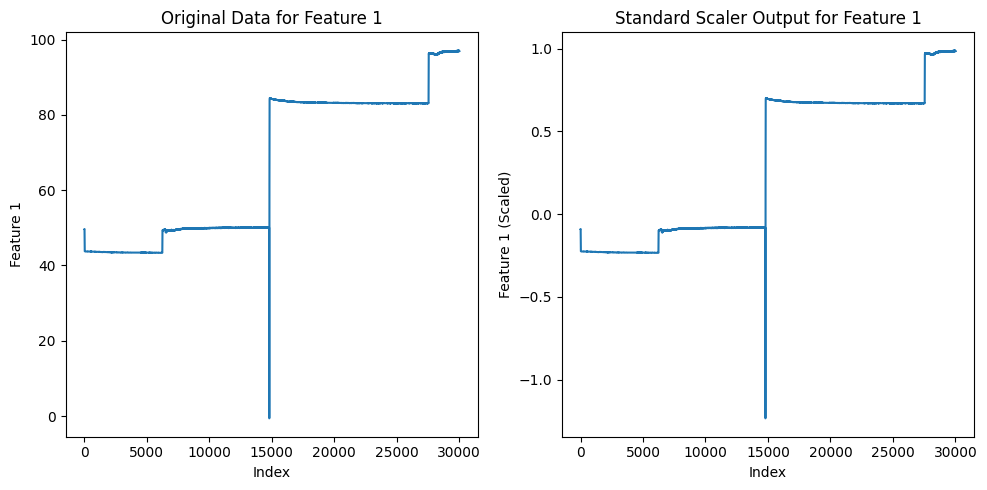

In [31]:
X_unscaled=scaler1.inverse_transform(X)
X_feature = X_unscaled[:30000, 0] 
# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(range(len(X_feature)), X_feature)
axs[0].set_title("Original Data for Feature 1")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Feature 1")


X_scaled_feature = X[:30000, 0]
axs[1].plot(range(len(X_scaled_feature)), X_scaled_feature)
axs[1].set_title("Standard Scaler Output for Feature 1")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Feature 1 (Scaled)")

plt.tight_layout()
plt.show()


### 4.Training

In [36]:
model = keras.Sequential([
    Input(shape=(X.shape[1])),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')
])
model.summary()


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


![](graphs/nn1.png)


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5)]

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.6)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=1,
    batch_size=32,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
    )

Epoch 1/100
16436/16436 [==============================] - 15s 923us/step - loss: 0.0945 - val_loss: 0.0749 - lr: 0.0010
Epoch 2/100
16436/16436 [==============================] - 15s 934us/step - loss: 0.0708 - val_loss: 0.0663 - lr: 0.0010
Epoch 3/100
16436/16436 [==============================] - 15s 924us/step - loss: 0.0658 - val_loss: 0.0645 - lr: 0.0010
Epoch 4/100
16436/16436 [==============================] - 15s 920us/step - loss: 0.0629 - val_loss: 0.0602 - lr: 0.0010
Epoch 5/100
16436/16436 [==============================] - 15s 916us/step - loss: 0.0610 - val_loss: 0.0625 - lr: 0.0010
Epoch 6/100
16436/16436 [==============================] - 15s 929us/step - loss: 0.0597 - val_loss: 0.0608 - lr: 0.0010
Epoch 7/100
16436/16436 [==============================] - 17s 1ms/step - loss: 0.0587 - val_loss: 0.0565 - lr: 0.0010
Epoch 8/100
16436/16436 [==============================] - 19s 1ms/step - loss: 0.0580 - val_loss: 0.0558 - lr: 0.0010
Epoch 9/100
16436/16436 [===========

### 5.Evaluation

In [15]:
evaluation=model.evaluate( X_test, y_test, verbose=1)

499/499 [==============================] - 0s 420us/step - loss: 0.0127


In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 4])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PM]')
  plt.legend()
  plt.grid(True)

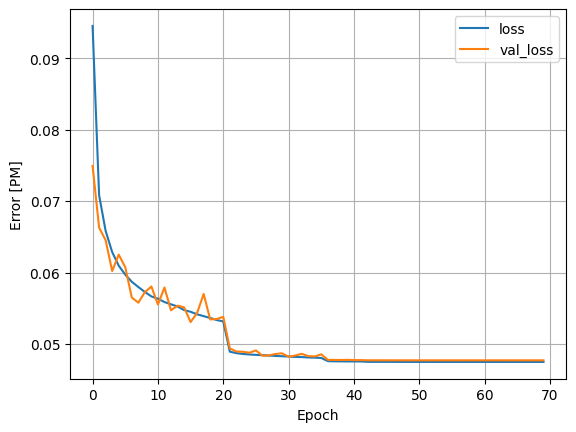

In [17]:
plot_loss(history)

### 6.Model Save & Load

In [67]:
if os.path.isdir("./saved_model") and os.path.isdir("./saved_model_weights") is False:
    os.mkdir("./saved_model")
    os.mkdir("./saved_model_weights")
    
model.save(f'./saved_model/model_03')
model.save(f'./saved_model_weights/model_0.3.h5')

INFO:tensorflow:Assets written to: ./saved_model/model_0.01\assets


In [37]:

model.load_weights('saved_model_weights/model_0.01.h5')

In [38]:

X = train_df[train_df['profile_id'] != 17].drop(columns = ['pm','profile_id'])
y = train_df['pm'][train_df['profile_id'] != 17]

X_test = train_df[train_df['profile_id'] == 17].drop(columns = ['pm','profile_id'])
y_test = train_df['pm'][train_df['profile_id'] == 17]

scaler1 = StandardScaler()
scaler2 = StandardScaler()
X = scaler1.fit_transform(X)
y = scaler2.fit_transform(np.asarray(y).reshape(-1, 1))

X_test = scaler1.transform(X_test)
y_test = scaler2.transform(np.asarray(y_test).reshape(-1, 1))

y_pred = model.predict(X_test)

y_pred = scaler2.inverse_transform(y_pred)
y_test = scaler2.inverse_transform(y_test)

print('Actual values:')
print(y_test[500])
print('Predicted values:')
print(y_pred[500])



 32/499 [>.............................] - ETA: 0s 

2023-04-20 14:04:38.066528: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


499/499 [==============================] - 1s 1ms/step
Actual values:
[40.103]
Predicted values:
[41.357]
